In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time
from bs4.element import Tag
import bs4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
from lxml import html
import lxml

## Searching for croissant baking temperatures
- Searches for 'croissant bake temperature' or 'temperature cuisson croissant' were conducted on Google country-specific search sites for the US, UK, and France. The first 100 links were obtained for each country. These links were subsequently scraped to determine if they were a croissant baking recipe, and if so, for their initial baking temperature.
- Baking temperatures were found by looking for sentences that contained the words 'preheat', 'bake', or 'oven' followed by a 3 digit number followed by a temperature indicator. 
- Croissant baking often employs a two-stage approach with a high starting temp followed by a lower finishing temp. The script pulled the first temperature mention, so this is the starting temp.
- For the US graphic, websites were excluded if the first temperature mention was in celsius.
- For the UK and French graphics, websites were excluded if the first temperature mention was in fahrenheit.


## Tools and techniques used in this project
- **Tools**
> - Python, Jupyter Lab, Beautiful Soup, Pandas, Numpy
- **Visualization**
> - Matplotlib
- **Techniques**
> - Web-scraping


In [2]:
def get_links_from_google_search(google_url):
    '''
    Given a Google search string, returns links from that Google search page
    Parameters:
    ----------
    google_url (str): a google search string. To get past the first page, replace start=0 with start={bundle}.
    Returns:
    -------
    links (list): a list of links 
    '''
    links_ = []
    driver = webdriver.Firefox()
    time.sleep(30) # slow requests down to keep google from getting upset
    driver.get(google_url)
    soup = BeautifulSoup(driver.page_source,'lxml')
    result_div = soup.find_all('div', attrs={'class': 'g'})
    for r in result_div:
            try:
                link = r.find('a', href=True)
                if link != '':
                    # site exceptions
                    if 'google.' not in link and 'costco.' not in link and 'freshdirect' not in link: 
                        links_.append(link['href'])
                
            except Exception as e:
                print(e)
                continue
    return(links_)


In [95]:
class ClassifyWebpage:
    '''Classify webpage'''
    def __init__(self, url, search_pattern_1, search_pattern_2):
        self.url = url
        self.page_type = ''
        self.language = "Not found in page source"
        self.pastry_recipe = PastryRecipeWebpage()

        try:
            r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'Mozilla/5.0'}) # Header assignment to avoid 403 errors
            if r.status_code == 406:
                r = requests.get(url, allow_redirects=False, headers={'User-Agent': 'XY'}) # Header assignment to avoid 406 errors
            if r.status_code == 200:
                print(f'Pass {url}')
                root = lxml.html.fromstring(r.text)
                language_construct = root.xpath("//html/@lang") # this xpath is reliable(in long-term), since this is a standard construct.
                if language_construct:
                    language = language_construct[0].split('-')[0]
                    self.language = language    
        
                soup = BeautifulSoup(r.content, 'html')
                all_text = soup.get_text()
                search_pattern_compiled = re.compile(search_pattern_1)
                bake_temp_inst = search_pattern_compiled.findall(all_text)
                # If baking step found within the instructions, assign 
                # instructions, initial temperature, and second stage temperature.
                if bake_temp_inst:
                    self.page_type = 'croissant recipe'
                    search_pattern_2_compiled = re.compile(search_pattern_2)
                    initial_bake_temp = int(search_pattern_2_compiled.search(bake_temp_inst[0])[0])
                    self.pastry_recipe = PastryRecipeWebpage(bake_temp_inst[0], initial_bake_temp)
            else:
                print(f'Fail {r.status_code}, {url}')
        except Exception as e:
            print('Exception', e)
            


In [96]:
class PastryRecipeWebpage:
    '''A recipe for hand-made croissants'''
    def __init__(self, instructions=None, initial_temp=None, second_temp=None):
        '''Initialize the recipe's attributes'''
        self.instructions = instructions
        self.initial_temp = initial_temp
        if initial_temp and initial_temp > 300:
            self.initial_temp_range = 'US'
        else:
            self.initial_temp_range = 'Europe'
        self.second_temp = second_temp
    

## Step one
### Get links for the target search term

In [12]:
#  The easiest way to change the search is to type a search in google then copy and paste the address.
#  Convert to an f string, find start=0 in the string and change it to start={bundle}.

# us_google_url=f"https://www.google.com/search?q=croissant+baking+temp&client=ubuntu&hs=bju&channel=fs&tbas=0&sxsrf=ALeKk01tinXVzgWJgZhSeeUfjrJd4FW4oA:1597161338731&ei=er8yX--YLLi50PEPiYu28A4&start={bundle}&sa=N&ved=2ahUKEwjvvfnRwZPrAhW4HDQIHYmFDe4Q8NMDegQIDhBA&biw=1920&bih=969"
# fr_google_url=f"https://www.google.fr/search?q=temp%C3%A9rature+cuisson+croissant&ei=0PEzX4C2PMXk-gTv_ImwCA&start={bundle}&sa=N&ved=2ahUKEwiA3szk5ZXrAhVFsp4KHW9-AoYQ8NMDegQIDRBC&biw=1848&bih=942"
# uk_google_url=f"https://www.google.co.uk/search?q=croissant+temperature&ei=OPQzX8T0KMj4-gSnn5moBw&start={bundle}&sa=N&ved=2ahUKEwjE8JaK6JXrAhVIvJ4KHadPBnUQ8NMDegQIDhA_&biw=1848&bih=942"

target_links = 140
page_bundles = list(range(0,target_links,10))
links=[]
for bundle in page_bundles:
    links_list = get_links_from_google_search(f"https://www.google.com/search?q=croissant+baking+temp&client=ubuntu&hs=bju&channel=fs&tbas=0&sxsrf=ALeKk01tinXVzgWJgZhSeeUfjrJd4FW4oA:1597161338731&ei=er8yX--YLLi50PEPiYu28A4&start={bundle}&sa=N&ved=2ahUKEwjvvfnRwZPrAhW4HDQIHYmFDe4Q8NMDegQIDhBA&biw=1920&bih=969")
    for link in links_list:
        links.append(link)

### Write results to file from Google search function

In [10]:
# Uncomment country to write results

# uk_croissant_links = pd.DataFrame(links)
# uk_croissant_links.to_csv('data/uk-croissant-links.txt')

# us_croissant_links = pd.DataFrame(links)
# us_croissant_links.to_csv('data/us-croissant-links.txt')

# fr_croissant_links = pd.DataFrame(links)
# fr_croissant_links.to_csv('data/fr-croissant-links.txt')

## Step two
### Read in links file and initiate web search

In [123]:
# url_list = pd.read_csv('data/uk-croissant-links.txt',header=None)
# url_list = pd.read_csv('data/us-croissant-links.txt',header=None)
url_list = pd.read_csv('data/fr-croissant-links.txt',header=None)

In [127]:
search_string_1 = r'([A-Z][^.]*(?:four|cuisson|cuir|chauff)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #French regex
# search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:ºC| ºC|°C| °C|C| C)[^.]*(?:[.]|[\s]))' #UK regex
# search_string_1 = r'([A-Z][^.]*(?:reheat|ake|oven)[^.]*\d{3}(?:º|°|F| ºF| °F| F|C| ºC| °C| C)[^.]*(?:[.]|[\s]))' #US regex
search_string_2 = r'(\d{3})'

good_url, instr, init_temp, init_temp_range = [], [], [], []
for i in range(len(url_list)):
    page = ClassifyWebpage(url_list[1][i], search_string_1, search_string_2)
    if page.pastry_recipe.instructions and page.pastry_recipe.initial_temp_range == 'Europe':
        good_url.append(page.url)
        instr.append(page.pastry_recipe.instructions)
        init_temp.append(page.pastry_recipe.initial_temp)
        init_temp_range.append(page.pastry_recipe.initial_temp_range)

df = pd.DataFrame([good_url, instr, init_temp]).T

Exception Invalid URL '0': No schema supplied. Perhaps you meant http://0?
Pass https://chefsimon.com/gourmets/chef-simon/recettes/croissants-et-pains-au-chocolat-decoupe-et-cuisson
Pass https://www.marmiton.org/recettes/recette_croissants-au-beurre-maison_41321.aspx
Pass https://cuisine.journaldesfemmes.fr/recette/305677-croissants-au-beurre
Pass https://www.meilleurduchef.com/en/recipe/pain-au-chocolat-chocolate-croissant.html
Pass https://www.iletaitunefoislapatisserie.com/2014/02/les-croissants-maison.html
Pass https://lacuisinedannie.20minutes.fr/recette-croissants-facon-boulangerie-355.html
Fail 301, http://www.lamourdupain.com/blogue/croissants-congeles
Pass https://zeste.ca/recettes/croissants-au-beurre-1
Pass http://www.mylittlerecettes.com/cap-patissier-croissants-pate-levee-feuilletee/
Pass https://fr.wikibooks.org/wiki/Livre_de_cuisine/Croissant
Pass https://www.aufeminin.com/recettes/les-croissants-s641549.html
Pass https://www.ricardocuisine.com/recettes/8475-croissants-a

In [130]:
df.iloc[:,2]

0     250
1     240
2     220
3     200
4     210
5     200
6     240
7     220
8     170
9     200
10    180
11    180
12    170
13    190
14    160
15    200
16    190
17    150
18    270
19    180
20    210
21    260
22    200
23    220
24    190
25    180
26    180
27    200
28    230
29    220
30    170
31    200
32    180
33    170
34    160
35    180
36    190
37    220
38    220
39    170
40    170
41    180
42    175
43    180
44    100
45    220
46    175
47    180
48    180
49    190
50    170
51    220
52    100
53    200
54    180
Name: 2, dtype: object

### Write search results to file

In [131]:
# Uncomment country to write results

# us_df = pd.DataFrame(df)
# us_df.to_csv('data/us_results.csv')

# uk_df = pd.DataFrame(df)
# uk_df.to_csv('data/uk_results.csv')

# fr_df = pd.DataFrame(df)
# fr_df.to_csv('data/fr_results.csv')

## Results and visualizations
- Of the 100 links obtained from the Google search by country, 35-40 usable temperatures were obtained for the US distribution and for the French distribution.
- Only 10 usable temperatures were obtained for the UK distribution. This is likely due to many recipes of US origin appearing in the google.uk search and being filtered out due to the restriction that temps needed to be expressed primarily in celsius.
- Mean temperatures are similar for all three countries.
- The distributions are different for the countries with the US having a narrower distribution of initial baking temperature and the French distribution being wider.

In [132]:
data_us = pd.read_csv('data/us_results.csv',header=None)
data_uk = pd.read_csv('data/uk_results.csv',header=None)
data_fr = pd.read_csv('data/fr_results.csv',header=None)

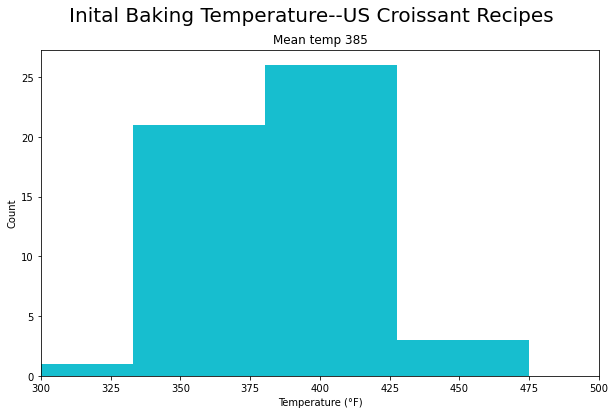

In [139]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(data_us.iloc[:,3], color='tab:cyan')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--US Croissant Recipes', size =20)
ax.set_title(f'Mean temp {data_us.iloc[:,3].mean():.0f}')
plt.savefig('img/us-croissant-baketemp-distribution.png')


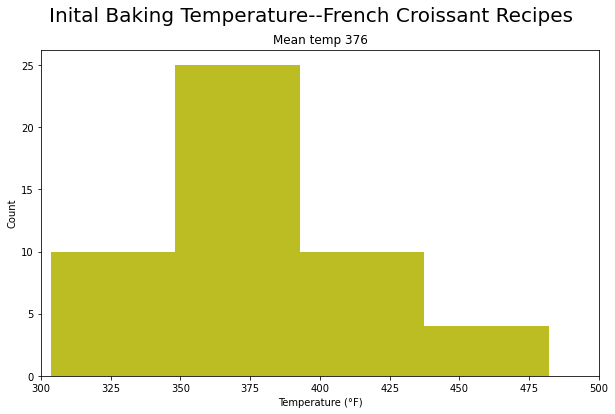

In [140]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_fr.iloc[:,3]*9/5+32), color='tab:olive')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--French Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_fr.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/fr-croissant-baketemp-distribution.png')
# (data_uk.iloc[:,2]*9/5+32).hist()
# (data_fr.iloc[:,2]*9/5+32).hist()


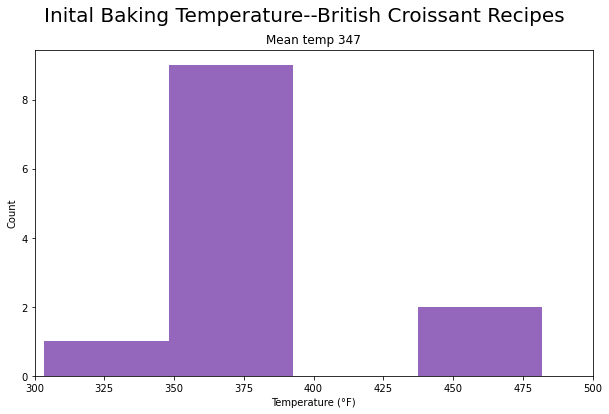

In [141]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist((data_uk.iloc[:,3]*9/5+32), color='tab:purple')
ax.set_ylabel('Count')
ax.set_xlabel('Temperature (°F)')
ax.set_xlim(300, 500)
fig.suptitle('Inital Baking Temperature--British Croissant Recipes', size =20)
ax.set_title(f'Mean temp {(data_uk.iloc[:,3]*9/5+32).mean():.0f}')
plt.savefig('img/uk-croissant-baketemp-distribution.png')


## Future Research
- Seek to obtain more usable temperatures by grabbing more links from Google and/or by refining the sifting of the websites to obtain a better yield.
- Consider how best to compare the distributions.
- Explore other parameters of croissant preparation and baking.
- Explore the comments for the various websites to determine if people in the respective countries interact differently with recipe authors.